<a href="https://colab.research.google.com/github/ggarciabas/ml_engineer/blob/dspipe/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline Fraude

- [sklearn pipes](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

## Leitura dos dados e isolamento (treino, teste e validação)

### Funções

In [1]:
def plot_fraudes_data (pdM, start=None, end=None)->tuple:
  pdf = pdM.copy()
  if start != None:
    pdf = pdf[(pdf['fecha_d']>=start)&(pdf['fecha_d']<=end)]
  pdf = pdf[['fecha_d', 'fraude','a']].groupby(['fecha_d', 'fraude']).count().reset_index()
  pdf = pdf.pivot(index="fecha_d", columns=["fraude"], values="a")
  print (f"Fraude {pdf[1].mean()} avg.\tGenuine: {pdf[0].mean()} avg.")
  pdf.plot()
  return pdf[1].sum(),pdf[0].sum()

### Leitura dos dados

In [2]:
import pandas as pd
# Cria Dataframe inicial
url='https://drive.google.com/file/d/1dRDvoSOtdtsgOG65UVKLTBlzejg_cX4P/view?usp=sharing' 
url2='https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
# https://stackoverflow.com/questions/56611698/pandas-how-to-read-csv-file-from-google-drive-public
pd_dados = pd.read_csv(url2)

In [3]:
# Filtra data sem hora
pd_dados['fecha_d'] = pd_dados['fecha'].apply(lambda x: x[:10])

In [4]:
pd_dados['fecha'] = pd.to_datetime(pd_dados['fecha'])
pd_dados['fecha_d'] = pd.to_datetime(pd_dados['fecha_d'])

### Feature store

Conhecimento de risco para categoria do produto e país.

Informação que precisa ser conhecida de tempos em tempos.

In [5]:
import math
def calc_risk (pdf, feat, delay=7, janelas=[1,7]):
    """
      Calcula o risco de fraude para feature
      pdf: dataframe com filtro feature a ser avaliada
      delay: prazo de identificação da fraude
      janelas: janelas de análise, como temos poucos dados faremos de 1 em 1 dia e de 7 em 7
    """
    pdf = pdf.sort_values('fecha_d')
    pdf = pdf.set_index('fecha_d')
    # quantidade de transações fraudulentas + contagem de transações --> no período de delay 
    fraudes = pdf['fraude'].rolling(f'{delay}d').sum()
    trxS = pdf['fraude'].rolling(f'{delay}d').count()
    for janela in janelas:
      fraudeJ = pdf['fraude'].rolling(f'{delay+janela}d').sum() 
      trxJ = pdf['fraude'].rolling(f'{delay+janela}d').count() 
      riskJ=(fraudeJ-fraudes)/(trxJ-trxS)
      riskJ = [0 if math.isnan(x) else x for x in riskJ]
      pdf[f'{feat}_trx_{janela}'] = list((trxJ-trxS))
      pdf[f'{feat}_risk_{janela}'] = list(riskJ)
    pdf = pdf.reset_index()
    return pdf

In [6]:
# feature_store = pd_dados.copy()
# feature_store = feature_store.groupby('j').apply(lambda x: calc_risk(x, 'j')).sort_values('fecha_d').reset_index(drop=True)
# feature_store = feature_store.groupby('g').apply(lambda x: calc_risk(x, 'g')).sort_values('fecha_d').reset_index(drop=True)

In [7]:
# feature_store[['fecha_d', 'g', 'g_trx_1', 'g_risk_1', 'g_trx_7', 'g_risk_7']].drop_duplicates().reset_index().to_csv('feature_store_g.csv', index=False)

In [8]:
# feature_store[['fecha_d', 'j', 'j_trx_1', 'j_risk_1', 'j_trx_7', 'j_risk_7']].drop_duplicates().reset_index().to_csv('feature_store_j.csv', index=False)

### Divide dados

- Treino: `2020-03-22` até `2020-03-28`
- Delay: `2020-03-29` até `2020-04-04`
- Teste: `2020-04-05` até `2020-04-11`

(20935, 21)
Fraude 163.42857142857142 avg.	Genuine: 2827.285714285714 avg.
Fraude: 1144 (0.054645330785765465)	Genuine: 19791 (0.9453546692142345)


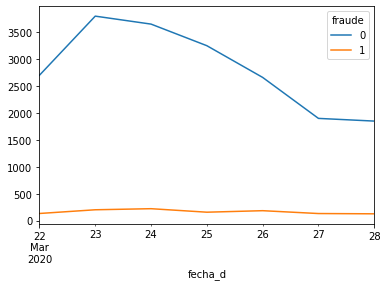

In [5]:
# Treino
dataTrain1 = {'start':'2020-03-22', 'end':'2020-03-28'}
pdfTrain1 = pd_dados.copy()
pdfTrain1 = pdfTrain1[(pdfTrain1['fecha_d']>=dataTrain1['start'])
                      &(pdfTrain1['fecha_d']<=dataTrain1['end'])]
print (pdfTrain1.shape)
fraude,genuine = plot_fraudes_data(pd_dados, dataTrain1['start'], dataTrain1['end'])
print (f"Fraude: {fraude} ({fraude/pdfTrain1.shape[0]})\tGenuine: {genuine} ({genuine/pdfTrain1.shape[0]})")

Fraude 142.71428571428572 avg.	Genuine: 2257.285714285714 avg.


(999, 15801)

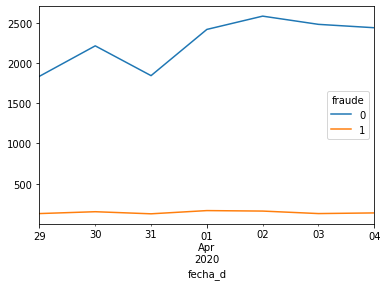

In [6]:
# Delay
dataDelay1 = {'start':'2020-03-29', 'end':'2020-04-04'}
plot_fraudes_data(pd_dados, dataDelay1['start'], dataDelay1['end'])

(24098, 21)
Fraude 188.0 avg.	Genuine: 3254.5714285714284 avg.
Fraude: 1316 (0.05461034110714582)	Genuine: 22782 (0.9453896588928542)


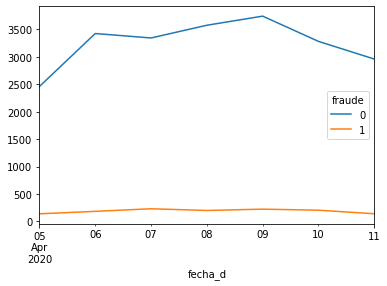

In [7]:
# Teste
dataTest1 = {'start':'2020-04-05', 'end':'2020-04-11'}
pdfTest1 = pd_dados.copy()
pdfTest1 = pdfTest1[(pdfTest1['fecha_d']>=dataTest1['start'])
                      &(pdfTest1['fecha_d']<=dataTest1['end'])]
print (pdfTest1.shape)
fraude,genuine = plot_fraudes_data(pd_dados, dataTest1['start'], dataTest1['end'])
print (f"Fraude: {fraude} ({fraude/pdfTest1.shape[0]})\tGenuine: {genuine} ({genuine/pdfTest1.shape[0]})")

## Classes

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

In [9]:
## Transformer para Risco de classes
import math
class RiskTransformer(BaseEstimator, TransformerMixin):
  """
    Calcula do risco para feature consultando na feature store
  """
  def __init__(self, feature_name, feat_store):
    self.feature_name = feature_name
    self.feat_store = feat_store

  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):    
    X_ = X.copy()
    X_ = X_.merge(self.feat_store, on=['fecha_d', self.feature_name], how='left')
    return X_

In [10]:
# Transformer para identificar final de semana
class IsWeekendTransformer(BaseEstimator, TransformerMixin):
  """
    Identifica se a operação ocorreu no final de semana
  """
  def __init__(self, feature_date):
    self.feature_date = feature_date

  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):    
    X_ = X.copy()
    X_['is_weekend'] = X_[self.feature_date].apply(lambda x: 1 if x.weekday()>=5 else 0)
    return X_

In [11]:
# Transformer para identificar operação noturna
class IsNinghtTransformer(BaseEstimator, TransformerMixin):
  """
    Identifica se a operação ocorreu durante a noite
  """
  def __init__(self, feature_date):
    self.feature_date = feature_date

  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):    
    X_ = X.copy()
    X_['is_night'] = X_[self.feature_date].apply(lambda x: 1 if x.hour<=6 or x.hour>=18 else 0)
    return X_

In [12]:
# Transformer para identificar se valor é nulo ou não
class IsNullTransformer(BaseEstimator, TransformerMixin):
  """
    Identifica se o valor é nulo ou não
  """
  def __init__(self, feature_name):
    self.feature_name = feature_name

  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):    
    X_ = X.copy()
    X_[f'is_{self.feature_name}_null'] = X_[self.feature_name].isna()
    X_[f'is_{self.feature_name}_null'] = X_[f'is_{self.feature_name}_null'].apply(lambda x: 1 if x else 0)
    return X_

In [13]:
# Transformer para identificar se valor Y ou N
class YNTransformer(BaseEstimator, TransformerMixin):
  """
    Identifica se o valor é verdadeiro ou falso (Y/N)
  """
  def __init__(self, feature_name):
    self.feature_name = feature_name

  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):    
    X_ = X.copy()
    X_[f'is_{self.feature_name}'] = X_[self.feature_name].apply(lambda x: 1 if x=='Y' else 0)
    return X_

In [14]:
# Transformer para selecionar colunas de interesse
class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
  """
    Seleciona as colunas indicadas
  """
  def __init__(self, features):
    self.features = features

  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):    
    X_ = X.copy()
    return X_[self.features]

In [68]:
# Transformer para definir média para colunas com nulos
class MeanTransformer(BaseEstimator, TransformerMixin):
  """
    Define valor médio para colunas com valores nulos
  """
  def __init__(self):
    pass

  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):    
    X_ = X.copy()
    return X_.fillna(X_.mean())

In [69]:
# Transformer para processar os dados
class ManualTransformer(BaseEstimator, TransformerMixin):
  """
    Processa as colunas do DF seguindo:
    - Cálculo de risco da coluna g e j
    - Identifica se a operação ocorreu no final de semana
    - Identifica se a operação ocorreu durante a noite
    - Identifica se a coluna o é nula ou não
    - Identifica se a coluna p é verdadeira ou falsa
  """
  def __init__(self, feat_store_g, feat_store_j, features):
    self.pipe_preproc = Pipeline([('risk_g', RiskTransformer(feature_name='g', feat_store=feat_store_g)), 
                                    ('risk_j', RiskTransformer(feature_name='j', feat_store=feat_store_j)), 
                                    ('is_weekend', IsWeekendTransformer(feature_date='fecha')), 
                                    ('is_night', IsNinghtTransformer(feature_date='fecha')), 
                                    ('is_o_null', IsNullTransformer(feature_name='o')), 
                                    ('is_p', YNTransformer(feature_name='p')),
                                    ('selector', SelectColumnsTransformer(features=features)),
                                    ('mean', MeanTransformer())
                                  ])

  def fit(self, X, y = None):    
    return self

  def transform(self, X, y = None):    
    X_ = X.copy()
    return self.pipe_preproc.fit_transform(X_)

## Pipelines

https://scikit-learn.org/stable/modules/model_evaluation.html

In [132]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import graphviz

In [150]:
def avalia_desempenho (pipe):
  print ("Treino")
  pred_treino = pipe.predict(pdfTrain1)
  print (confusion_matrix(pred_treino, pdfTrain1[target], labels=[1,0]))
  print (classification_report(pred_treino, pdfTrain1[target], labels=[1,0]))

  print ('Teste')
  pred_teste = pipe.predict(pdfTest1)
  print (confusion_matrix(pred_teste, pdfTest1[target], labels=[1,0]))
  print (classification_report(pred_teste, pdfTest1[target], labels=[1,0]))

In [17]:
# Carrega a feature store
feat_store_j = pd.read_csv('feature_store_j.csv')
feat_store_j['fecha_d'] = pd.to_datetime(feat_store_j['fecha_d'])

feat_store_g = pd.read_csv('feature_store_g.csv')
feat_store_g['fecha_d'] = pd.to_datetime(feat_store_g['fecha_d'])

In [90]:
# Variáveis
target = 'fraude'

features = ['a', 'b', 'c', 'd', 'e', 'f', 'h', 'k', 'l', 'm', 'n',
          'monto', 'g_trx_1', 'g_risk_1', 'g_trx_7', 'g_risk_7', 'j_trx_1',
          'j_risk_1', 'j_trx_7', 'j_risk_7', 'is_weekend', 'is_night',
          'is_o_null', 'is_p']

In [ ]:
# {'Logistic regression': {'modelo':sklearn.linear_model.LogisticRegression(random_state=42)},
#             'Decision tree baseline': {'modelo': sklearn.tree.DecisionTreeClassifier(max_depth=2,random_state=42)},
#             'Decision tree - auto depth': {'modelo':sklearn.tree.DecisionTreeClassifier(random_state=42)}, 
#             #'Random forest': {'modelo':sklearn.ensemble.RandomForestClassifier(random_state=42,n_jobs=-1)},

### Score atual

In [149]:
print ("Treino")
score_train1 = pdfTrain1['score'].apply(lambda x: 0 if x<86 else 1) # corte do lucro máximo
print (confusion_matrix(score_train1, pdfTrain1[target], labels=[1,0]))
print(classification_report(score_train1, pdfTrain1[target], labels=[1,0]))

print ("Teste")
score_test1 = pdfTest1['score'].apply(lambda x: 0 if x<86 else 1) # corte do lucro máximo
print (confusion_matrix(score_test1, pdfTest1[target], labels=[1,0]))
print(classification_report(score_test1, pdfTest1[target], labels=[1,0]))

Treino
[[  593  2935]
 [  551 16856]]
              precision    recall  f1-score   support

           1       0.52      0.17      0.25      3528
           0       0.85      0.97      0.91     17407

    accuracy                           0.83     20935
   macro avg       0.69      0.57      0.58     20935
weighted avg       0.80      0.83      0.80     20935

Teste
[[  619  1440]
 [  697 21342]]
              precision    recall  f1-score   support

           1       0.47      0.30      0.37      2059
           0       0.94      0.97      0.95     22039

    accuracy                           0.91     24098
   macro avg       0.70      0.63      0.66     24098
weighted avg       0.90      0.91      0.90     24098



### Decision Tree

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


#### Baseline

In [151]:
pipe_dt_bsl = Pipeline([('preprocess', ManualTransformer(feat_store_j=feat_store_j, feat_store_g=feat_store_g, features=features)),
                        # ('scaler', StandardScaler()),
                        ('dt baseline', DecisionTreeClassifier(random_state=42))
                    ])
pipe_dt_bsl = pipe_dt_bsl.fit(pdfTrain1, pdfTrain1[target])

avalia_desempenho (pipe_dt_bsl)

Treino
[[ 1144     0]
 [    0 19791]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1144
           0       1.00      1.00      1.00     19791

    accuracy                           1.00     20935
   macro avg       1.00      1.00      1.00     20935
weighted avg       1.00      1.00      1.00     20935

Teste
[[  333  1592]
 [  983 21190]]
              precision    recall  f1-score   support

           1       0.25      0.17      0.21      1925
           0       0.93      0.96      0.94     22173

    accuracy                           0.89     24098
   macro avg       0.59      0.56      0.57     24098
weighted avg       0.88      0.89      0.88     24098



In [125]:
# display(graphviz.Source(export_graphviz(pipe_dt_bsl['dt baseline'], feature_names=features, class_names=True, filled=True)))

#### Random Search

In [146]:
param_dist = {
    "max_depth": range(2,20,2),
    "min_samples_split": [2, 10, 50, 100, 200],
    "min_samples_leaf": [1, 10, 50, 100, 200],
    "max_features": ['auto', 'sqrt', 'log2'],
    'class_weight': [{0:0.1, 1:1}]
}

In [154]:
pipe_dt_Rnd = Pipeline([('preprocess', ManualTransformer(feat_store_j=feat_store_j, feat_store_g=feat_store_g, features=features)),
                        # ('scaler', StandardScaler()),
                        ('DT random', RandomizedSearchCV(DecisionTreeClassifier(random_state=42), 
                                                          param_distributions=param_dist, 
                                                          n_iter=20,
                                                          scoring='f1',
                                                          cv = 10,
                                                          random_state=42
                                                        ))
                    ])
pipe_dt_Rnd = pipe_dt_Rnd.fit(pdfTrain1, pdfTrain1[target])
avalia_desempenho (pipe_dt_Rnd)

Treino
[[  722  2452]
 [  422 17339]]
              precision    recall  f1-score   support

           1       0.63      0.23      0.33      3174
           0       0.88      0.98      0.92     17761

    accuracy                           0.86     20935
   macro avg       0.75      0.60      0.63     20935
weighted avg       0.84      0.86      0.83     20935

Teste
[[  592  2809]
 [  724 19973]]
              precision    recall  f1-score   support

           1       0.45      0.17      0.25      3401
           0       0.88      0.97      0.92     20697

    accuracy                           0.85     24098
   macro avg       0.66      0.57      0.58     24098
weighted avg       0.82      0.85      0.82     24098



### Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#### Baseline

In [129]:
pipe_rf_bsl = Pipeline([('preprocess', ManualTransformer(feat_store_j=feat_store_j, feat_store_g=feat_store_g, features=features)),
                        # ('scaler', StandardScaler()),
                        ('rf baseline', RandomForestClassifier(random_state=42, n_jobs=-1))
                    ])
pipe_rf_bsl = pipe_rf_bsl.fit(pdfTrain1, pdfTrain1[target])
pipe_rf_bsl_pred = pipe_rf_bsl.predict(pdfTrain1)

print (confusion_matrix(pipe_rf_bsl_pred, pdfTrain1[target], labels=[1,0]))
print (classification_report(pipe_rf_bsl_pred, pdfTrain1[target], labels=[1,0]))

[[ 1143     0]
 [    1 19791]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1143
           0       1.00      1.00      1.00     19792

    accuracy                           1.00     20935
   macro avg       1.00      1.00      1.00     20935
weighted avg       1.00      1.00      1.00     20935



#### Random Search

In [155]:
param_dist = {
    "max_depth": range(2,20,2),
    "min_samples_split": [2, 10, 50, 100, 200],
    "min_samples_leaf": [1, 10, 50, 100, 200],
    "max_features": ['auto', 'sqrt', 'log2'],
    'class_weight': [{0:0.1, 1:1}]
}

In [156]:
pipe_rf_Rnd = Pipeline([('preprocess', ManualTransformer(feat_store_j=feat_store_j, feat_store_g=feat_store_g, features=features)),
                        # ('scaler', StandardScaler()),
                        ('RF random', RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), 
                                                          param_distributions=param_dist, 
                                                          n_iter=20,
                                                          scoring='f1',
                                                          cv = 10,
                                                          random_state=42
                                                        ))
                    ])
pipe_rf_Rnd = pipe_rf_Rnd.fit(pdfTrain1, pdfTrain1[target])
avalia_desempenho (pipe_rf_Rnd)

Treino
[[  853   619]
 [  291 19172]]
              precision    recall  f1-score   support

           1       0.75      0.58      0.65      1472
           0       0.97      0.99      0.98     19463

    accuracy                           0.96     20935
   macro avg       0.86      0.78      0.81     20935
weighted avg       0.95      0.96      0.95     20935

Teste
[[  465   849]
 [  851 21933]]
              precision    recall  f1-score   support

           1       0.35      0.35      0.35      1314
           0       0.96      0.96      0.96     22784

    accuracy                           0.93     24098
   macro avg       0.66      0.66      0.66     24098
weighted avg       0.93      0.93      0.93     24098



### Logistc Regression

In [127]:
pipe_lr_bsl = Pipeline([('preprocess', ManualTransformer(feat_store_j=feat_store_j, feat_store_g=feat_store_g, features=features)),
                        # ('scaler', StandardScaler()),
                        ('lr baseline', LogisticRegression(random_state=42))
                    ])
pipe_lr_bsl = pipe_lr_bsl.fit(pdfTrain1, pdfTrain1[target])
pipe_lr_bsl_pred = pipe_lr_bsl.predict(pdfTrain1)

print (confusion_matrix(pipe_lr_bsl_pred, pdfTrain1[target], labels=[1,0]))
print (classification_report(pipe_lr_bsl_pred, pdfTrain1[target], labels=[1,0]))

[[    1     3]
 [ 1143 19788]]
              precision    recall  f1-score   support

           1       0.00      0.25      0.00         4
           0       1.00      0.95      0.97     20931

    accuracy                           0.95     20935
   macro avg       0.50      0.60      0.49     20935
weighted avg       1.00      0.95      0.97     20935



### XGBoost

In [69]:
import xgboost

In [ ]:
pipeXGB = Pipeline([('preprocess', ManualTransformer(feat_store_j=feat_store_j, feat_store_g=feat_store_g, features=feat)),
                      ('xgb', xgboost.XGBClassifier(random_state=42, n_jobs=-1))
                    ])
pipeXGB.fit(pdfTrain1, pdfTrain1[target])
out_train = pipeXGB.transform(pdfTrain1)
out_train[:2]

## Old

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
pipe_preproc = Pipeline([('preprocess', ManualTransformer(feat_store_j=feat_store_j, feat_store_g=feat_store_g, features=features)),
                        # ('risk_g', RiskTransformer(feature_name='g', feat_store=feat_store_g)), 
         
                        # ('risk_j', RiskTransformer(feature_name='j', feat_store=feat_store_j)), 
                        # ('is_weekend', IsWeekendTransformer(feature_date='fecha')), 
                        # ('is_night', IsNinghtTransformer(feature_date='fecha')), 
                        # ('is_o_null', IsNullTransformer(feature_name='o')), 
                        # ('is_p', YNTransformer(feature_name='p')),
                        # ('selector', SelectColumnsTransformer(features=features)),
                        # ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                        # ('scaler', StandardScaler()),
                        # ('dt baseline', DecisionTreeClassifier(max_depth=2,random_state=42))
                    ])